# About the code
"Text about the code and its usage"

# Packages

In [1]:
pip install pysimplegui


Note: you may need to restart the kernel to use updated packages.


In [2]:
import PySimpleGUI as sg
import ipywidgets 
import numpy as np
import matplotlib.pyplot as plt
from tabulate import tabulate as tb
import pandas as pd

# Data Entry via gui

In [3]:

# Define the layout for the window
sg.theme('Default1')      # Add some color to the window
layout = [
    [sg.Text('Inputs to Analyze Sensitivity of EDL Model', size=(50, 1), justification='center', font=('Helvetica', 20,'bold'))],
    [sg.Column([
        [sg.Text('Initial State', size=(26, 1), font=('Helvetica', 12, 'bold'))],
        [sg.Text('Free Energy (eV)', size=(26, 1)), sg.InputText(size=(25, 1))],
        [sg.Text('Dipole Moment', size=(26, 1)), sg.InputText(size=(25, 1))],
        [sg.Text('Polarizability', size=(26, 1)), sg.InputText(size=(25, 1))],
        [sg.Text('Bare Surface Parameters', size=(26, 1), font=('Helvetica', 12, 'bold'))],
        [sg.Text('Volume of the Cell (A^3)', size=(26, 1)), sg.InputText(size=(25, 1))],
        [sg.Text('Height of the Cell (A)', size=(26, 1)), sg.InputText(size=(25, 1))],
        [sg.Text('Fermi Energy (eV)', size=(26, 1)), sg.InputText(size=(25, 1))],
        [sg.Text('Vacuum Potential (eV)', size=(26, 1)), sg.InputText(size=(25, 1))],
        [sg.Text('Bare Metal Polarizability (eV)', size=(26, 1)), sg.InputText(size=(25, 1))],
        [sg.Text('Potential Range of Interest', size=(26, 1), font=('Helvetica', 12, 'bold'))],
        [sg.Text('Lower Limit  (V-NHE)', size=(26, 1)), sg.InputText(size=(25, 1))],
        [sg.Text('Upper Limit (V-NHE)', size=(26, 1)), sg.InputText(size=(25, 1))],
    ]), sg.VerticalSeparator(pad=((20, 20), (10, 10))), 
     sg.Column([
        [sg.Text('Final State', size=(26, 1), font=('Helvetica', 12, 'bold'))],
        [sg.Text('Free Energy (eV)', size=(26, 1)), sg.InputText(size=(25, 1))],
        [sg.Text('Dipole Moment', size=(26, 1)), sg.InputText(size=(25, 1))],
        [sg.Text('Polarizability', size=(26, 1)), sg.InputText(size=(25, 1))],
        [sg.Text('EDL Model Parameters', size=(26, 1), font=('Helvetica', 12, 'bold'))],
        [sg.Text('Relative Permittivity', size=(26, 1)), sg.InputText(size=(25, 1))],
        [sg.Text('Width of the EDL (A)', size=(26, 1)), sg.InputText(size=(25, 1))],
        [sg.Text('Vacuum to NHE (V-NHE)', size=(26, 1)), sg.InputText(size=(25, 1))],
        [sg.Text('Solvation Free Energy Change (eV)', size=(26, 1)), sg.InputText(size=(25, 1))],
         [sg.Button('Submit', size=(40, 3), button_color=('white', 'blue'), pad=(70, 30))]
         ,])],
    
    
]

# Create the window
window = sg.Window('Window Title', layout, size=(900, 450),element_justification='c')
# Event loop to process events and get input
while True:
    event, values = window.read()
    if event == sg.WINDOW_CLOSED or event == 'Submit':
        break

# Close the window
window.close()


# Data Processing

In [4]:
# Input stored as a dictionary and converted to floats (Last three indexes are boolean)
for index in range(18):
    if index != 10:
        values[index] = float(values[index])

polar_bare = values[7]
       
# Initial
e_in = values[0]
dm_in = values[1]
polar_in = values[2]-polar_bare

# Cell Parameters
v = values[3]
h = values[4]
e_fermi = values[5]
u_vac = values[6]

u_low = values[8]
u_high = values[9]

# Final
e_fin = values[11]
dm_fin = values[12]
polar_fin = values[13]-polar_bare

# EDL Model Parameters
er = values[14]
d = values[15]
vac_nhe = values[16]
g_solv = values[17]


In [5]:
#Dipole moment and Polarizability Changes
diff_dm = dm_fin - dm_in
diff_polar = polar_fin - polar_in

#Constants for the cell
a=v/h # area of the slab (A^2)
wf_bare = u_vac-e_fermi #Work function of the bare metal surface
u_pzc = wf_bare - vac_nhe #Potential of zero charge of the bare surface

#Constants related to EDL model
e_vac = 0.00553 #vacuum permittivity
e=er*e_vac #complex permittivity

u = np.linspace(u_low,u_high,25)
u_prime = u - u_pzc


# Sensitivity Analysis due to EDL Complexities

In [6]:
# Model 1A: Free Energy Change at U_PZC
g_1a = e_fin - e_in + g_solv + wf_bare - vac_nhe

# Model 1B: Potenital dependent Free Energy Change assuming Beta = 1 (Full e- transfer)
g_1b = g_1a+u_prime


In [7]:
#Model 2A: Incorporate Capacitance Charge
C = er*a*e_vac/d # Predicted Capacitiance by Helmholtz Model
diff_dm_sq = (dm_fin ** 2 - dm_in ** 2) 
# 0th order capacitance
C_0 = -0.5 * (diff_dm_sq) / (C * d ** 2)
#  1st order wrt U'
diff_dm = round(dm_fin - dm_in, 2)
C_const_1 = diff_dm / d
C_1 = C_const_1 * u_prime
#  Total Capacitance
c_total = C_0 + C_1 #  Total Capacitance
# Free Energy Change to correct Model 1B with Charging
g_2a = g_1b + c_total



#Model 2B: Incorporating Dipole-Field Terms
dm_0 = 2 * C_0
dm_1 = u_prime * C_const_1
dm_total = dm_0 + dm_1
# Calculate G_2B to correct Model 2A with dipole-field terms
g_2b = g_2a + dm_total



#Model 2C: Incorporating Polarizability (Induced Dipole-Field Terms)
diff_dm_polar_sq = (polar_fin*(dm_fin)*dm_fin-polar_in*dm_in*dm_in)
diff_a_dm = polar_fin*dm_fin-polar_in*dm_in
# Polarizability 0th order
p_0_d = 2*(e**2)*(a**2)*(d**2)
p_0 = diff_dm_polar_sq/p_0_d
# Polarizability 1st order
p_1_d=e*a*d**2
p_1 = -u_prime*diff_a_dm/p_1_d
# Polarizability 2nd order
p_2 = 0.5*(u_prime**2)*(diff_polar)*(1/d)*(1/d)
# Polarizability total
p_total = p_0 + p_1 + p_2 
#Calculate G_2C
g_2c=g_2b+p_total

### Free Energy vs Potential for different EDL Models

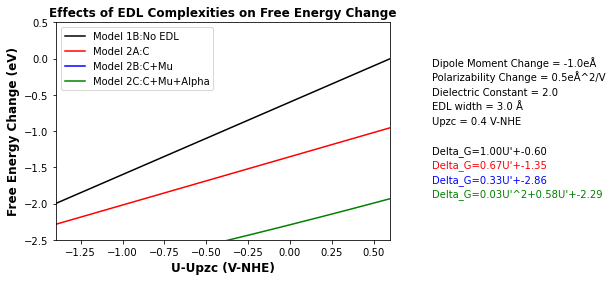

Dielectric Constant = 2.00 EDL Width = 3.00  A 
Dipole Moment Change = -1.00 Polarizability Change = 0.50
+---------+------------------------------+
| Model   | Delta_G vs U-Upzc Equation   |
+=========+==============================+
| 1B      | 1.00U'+-0.60                 |
+---------+------------------------------+
| 2A      | 0.67U'+-1.35                 |
+---------+------------------------------+
| 2B      | 0.33U'+-2.86                 |
+---------+------------------------------+
| 2C      | 0.03U'^2+0.58U'+-2.29        |
+---------+------------------------------+


In [8]:
#Calculate the roots
Model =['1b','2a','2b']
for i in Model:
    globals()['TL_'+i]=np.polyfit(u_prime,globals()['g_'+i],1) #Solve coefficents
    globals()['TL_'+i+'_1'] = np.poly1d(globals()['TL_'+i]) #Put coefficients into a polynomial


#2c model
TL_2c = np.polyfit(u_prime,g_2c,2)
TL_2c_1 = np.poly1d(TL_2c)


# Create Figure
fig= plt.figure()
ap2=fig.add_subplot(111) #rows,columns,subgraph
ap2.plot(u_prime,TL_1b_1(u_prime),c='k',label="Model 1B:No EDL")
ap2.plot(u_prime,TL_2a_1(u_prime),c='r',label="Model 2A:C")
ap2.plot(u_prime,TL_2b_1(u_prime),c='b',label="Model 2B:C+Mu")
ap2.plot(u_prime,TL_2c_1(u_prime),c='g',label="Model 2C:C+Mu+Alpha")

#Figure Parameters
plt.legend(loc='best')
plt.xlabel('U-Upzc (V-NHE)', fontweight = 'bold', fontsize = 12)
plt.ylabel('Free Energy Change (eV)', fontweight = 'bold', fontsize = 12)
plt.title('Effects of EDL Complexities on Free Energy Change', fontweight = 'bold', fontsize = 12)
plt.axis([u_prime[0],u_prime[-1],g_1b[0]-0.5,g_1b[-1]+0.5])

plt.text(0.25 + u_prime[-1], g_1b[-1]-0.1, "Dipole Moment Change = " + str(round(diff_dm, 2)) + "eÅ")
plt.text(0.25 + u_prime[-1], g_1b[-1]-0.3, "Polarizability Change = " + str(round(diff_polar, 2)) + "eÅ^2/V")
plt.text(0.25+u_prime[-1],g_1b[-1]-0.5,"Dielectric Constant = "+str(er))
plt.text(0.25+u_prime[-1],g_1b[-1]-0.7,"EDL width = " +str(d) + " Å")
plt.text(0.25+u_prime[-1],g_1b[-1]-0.9,"Upzc = " +str(round(u_pzc, 2)) + " V-NHE")
plt.text(0.25+u_prime[-1],g_1b[-1]-1.3,"Delta_G=%.2fU'+%.2f"%(TL_1b[0],TL_1b[1]),c='k')
plt.text(0.25+u_prime[-1],g_1b[-1]-1.5,"Delta_G=%.2fU'+%.2f"%(TL_2a[0],TL_2a[1]),c='r')
plt.text(0.25+u_prime[-1],g_1b[-1]-1.7,"Delta_G=%.2fU'+%.2f"%(TL_2b[0],TL_2b[1]),c='b')
plt.text(0.25+u_prime[-1],g_1b[-1]-1.9,"Delta_G=%.2fU'^2+%.2fU'+%.2f"%(TL_2c[0],TL_2c[1],TL_2c[2]),c='g')

plt.show()

print("Dielectric Constant =","{:.2f}".format(er), "EDL Width =","{:.2f}".format(d)," A ")
print("Dipole Moment Change =","{:.2f}".format(diff_dm), "Polarizability Change =","{:.2f}".format(diff_polar))
table_U0 = [['Model','Delta_G vs U-Upzc Equation'],['1B',"%.2fU'+%.2f"%(TL_1b[0],TL_1b[1])],['2A',"%.2fU'+%.2f"%(TL_2a[0],TL_2a[1])],['2B',"%.2fU'+%.2f"%(TL_2b[0],TL_2b[1])],['2C',"%.2fU'^2+%.2fU'+%.2f"%(TL_2c[0],TL_2c[1],TL_2c[2])]]
print(tb(table_U0,headers='firstrow',tablefmt = 'grid'))


### Compartmentalizing EDL Complexities as a Function of Electrode Potential 

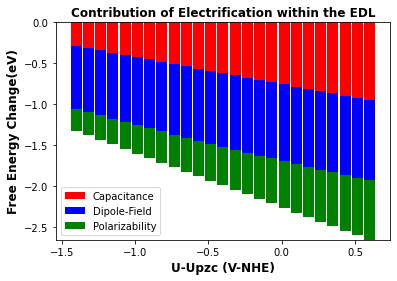

In [9]:

plt.bar(u_prime,c_total,0.075,label="Capacitance",color='red')
plt.bar(u_prime,dm_total,0.075,bottom=c_total,label="Dipole-Field",color='blue')
plt.bar(u_prime,p_total,0.075,bottom=[c_total[i] + dm_total[i] for i in range(len(dm_total))],label="Polarizability",color='green')
#plt.bar(u_prime,p_total,0.075,label="Polarizability",color='green')
plt.legend(loc='best')
plt.xlabel("U-Upzc (V-NHE)", fontweight = 'bold', fontsize = 12)
plt.ylabel("Free Energy Change(eV)", fontweight = 'bold', fontsize = 12)
plt.title("Contribution of Electrification within the EDL" , fontweight = 'bold', fontsize = 12)
total = np.abs(c_total) + np.abs(dm_total) + np.abs(p_total)
#plt.xlim([u_prime[0]-0.5,u_prime[-1]+0.5])


#plt.text(0.25 + u_prime[-1], g_1b[-1]-0.1, "Dipole Moment Change = " + str(round(diff_dm, 2)) + "eA")
#plt.text(0.25 + u_prime[-1], g_1b[-1]-0.3, "Polarizability Change = " + str(round(diff_polar, 2)) + "eA^2/V")
#plt.text(0.25+u_prime[-1],g_1b[-1]-0.5,"Dielectric Constant = "+str(er))
#plt.text(0.25+u_prime[-1],g_1b[-1]-0.7,"EDL width = " +str(d) + " A")
#plt.text(0.25+u_prime[-1],g_1b[-1]-0.9,"Upzc = " +str(round(u_pzc, 2)) + " V-NHE")

# Sensitivity Analysis due to Dielectric Constant and Width of EDL

In [10]:
def plot_2c(er=1,d=1):
    #Model 2A: Incorporate Capacitance Charge
    C = er*a*e_vac/d # Predicted Capacitiance by Helmholtz Model
    diff_dm_sq = (dm_fin ** 2 - dm_in ** 2) 
    # 0th order capacitance
    C_0 = -0.5 * (diff_dm_sq) / (C * d ** 2)
    #  1st order wrt U'
    diff_dm = round(dm_fin - dm_in, 2)
    C_const_1 = diff_dm / d
    C_1 = C_const_1 * u_prime
    #  Total Capacitance
    c_total = C_0 + C_1 #  Total Capacitance
    # Free Energy Change to correct Model 1B with Charging
    g_2a = g_1b + c_total

    #Model 2B: Incorporating Dipole-Field Terms
    dm_0 = 2 * C_0
    dm_1 = u_prime * C_const_1
    dm_total = dm_0 + dm_1
    # Calculate G_2B to correct Model 2A with dipole-field terms
    g_2b = g_2a + dm_total

    #Model 2C: Incorporating Polarizability (Induced Dipole-Field Terms)
    diff_dm_polar_sq = (polar_fin*(dm_fin)*dm_fin-polar_in*dm_in*dm_in)
    diff_a_dm = polar_fin*dm_fin-polar_in*dm_in
    # Polarizability 0th order
    p_0_d = 2*(e**2)*(a**2)*(d**2)
    p_0 = diff_dm_polar_sq/p_0_d
    # Polarizability 1st order
    p_1_d=e*a*d**2
    p_1 = -u_prime*diff_a_dm/p_1_d
    # Polarizability 2nd order
    p_2 = 0.5*(u_prime**2)*(diff_polar)*(1/d)*(1/d)
    # Polarizability total
    p_total = p_0 + p_1 + p_2 
    #Calculate G_2C
    g_2c=g_2b+p_total


    # Sensitivity Plot
    # Plot scatter point at Equilibrium Potential
    # Plot Scatter at U_pzc
    plt.figure(figsize=(10, 8))
    plt.plot(u_prime, g_2c)
    plt.plot(u_prime,[0]*len(u_prime),'r--',label='Free Energy Change = 0 eV')
    plt.title('Sensitivity to approximation of EDL width and Dielectric Constant',fontweight = 'bold', fontsize = 16)
    plt.xlabel('U-Upzc (V-NHE)')
    plt.ylabel('Free Energy Change (eV)')
    plt.grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.5)
    #plt.ylim(g_2c[0],g_2c[-1])
    #plt.yticks(np.arange(round(g_2c[0]), round(g_2c[-1])))

    plt.legend()
    



In [11]:
import ipywidgets as widgets
ipywidgets.interact(plot_2c,er=(1,78.5,0.5),d=(1,50,0.5))

interactive(children=(FloatSlider(value=1.0, description='er', max=78.5, min=1.0, step=0.5), FloatSlider(value…

<function __main__.plot_2c(er=1, d=1)>

# Beta Calculator as a function of EDL Width

In [18]:

def beta_plot(d_int=1):
    beta_avg_values = []
    d_range = np.linspace(1,20,33)
    if diff_dm > 0:
        for d in d_range:
            e = 1  # absolute charge of one electron
            a_beta = diff_polar / (2 * d ** 2)
            b_beta = 2 * diff_dm / d - (dm_in * diff_polar) / (e * a * d ** 2)
            beta = b_beta + 2 * a_beta * u_prime  # eq 31 calculate as function of U wrt to Upzc
            beta_avg = sum(beta) / len(beta)
            beta_avg_values.append(beta_avg)         
    else:
        for d in d_range:
            e = 1  # absolute charge of one electron
            a_beta = diff_polar/ (2 * d ** 2)
            b_beta = 1 + 2 * diff_dm / d - (dm_in * diff_polar) / (e * a * d ** 2)
            beta = b_beta + 2 * a_beta * u_prime  # eq 31 calculate as function of U wrt to Upzc
            beta_avg = sum(beta) / len(beta)
            beta_avg_values.append(beta_avg)
    if diff_dm > 0:
        e = 1  # absolute charge of one electron
        a_beta_int = diff_polar / (2 * d_int ** 2)
        b_beta_int = 2 * diff_dm / d_int - (dm_in * diff_polar) / (e * a * d_int ** 2)
        beta_int = b_beta_int + 2 * a_beta_int * u_prime  # eq 31 calculate as function of U wrt to Upzc
        beta_avg_int = sum(beta_int) / len(beta_int)
        #beta_avg_values_int.append(beta_avg_int)         
    else:
        e = 1  # absolute charge of one electron
        a_beta_int = diff_polar/ (2 * d_int ** 2)
        b_beta_int = 1 + 2 * diff_dm / d_int - (dm_in * diff_polar) / (e * a * d_int ** 2)
        beta_int = b_beta_int + 2 * a_beta_int * u_prime  # eq 31 calculate as function of U wrt to Upzc
        beta_avg_int = sum(beta_int) / len(beta_int)
        #beta_avg_values_int.append(beta_avg_int)       



    # plot the results
    plt.figure(figsize=(10, 8))
    plt.scatter(d_int,beta_avg_int,color='red',label = 'Predicted Beta')
    plt.plot(d_range, beta_avg_values, label='Beta', color = 'blue')
    plt.plot([d_int,d_int],[0,beta_avg_int],"r--")
    plt.plot([0,d_int],[beta_avg_int,beta_avg_int],"r--")
    plt.title('Dependence of Beta on Estimated EDL Width',fontweight = 'bold', fontsize = 16)
    plt.legend(loc='lower right')
    plt.xlabel('Width of the EDL (Å)',fontsize=20)
    plt.ylabel('Net Electron Transfer (e)',fontsize=20)
    plt.xlim(d_range[0],d_range[-1])
    plt.xticks(np.arange(min(d_range), max(d_range), 1))
    plt.ylim(0,1)
    plt.tick_params(axis='x', labelsize=20)
    plt.tick_params(axis='y', labelsize=16)
    plt.yticks(np.arange(0, 1.05, step=0.05))
    plt.text(d_range[-1]+1,0.65,  'UPZC='+str(round(u_pzc,2))+'V-NHE', fontsize=18)
    plt.text(d_range[-1]+1,0.6, 'Dipole Moment Change='+str(round(diff_dm,2))+'eÅ', fontsize=18)
    plt.text(d_range[-1]+1,0.55, 'Beta ='+str(round(beta_avg_int,2))+' at EDL Width ='+str(round(d_int,2))+'Å', fontsize=18)
    plt.grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.5)
    plt.show()
    
    
    # Combine the lists into a list of lists
    data = [list(x) for x in zip(d_range, beta_avg_values)]

    # Define the headers for the table
    headers = ["d", "beta", "EV_2B"]

    # Print the table
    print(tb(data, headers=headers))



The history saving thread hit an unexpected error (OperationalError('database or disk is full')).History will not be written to the database.


In [19]:
import ipywidgets as widgets
ipywidgets.interact(beta_plot,d_int=(1,20,0.125)) #d_int=(min,max, interval)

interactive(children=(FloatSlider(value=1.0, description='d_int', max=20.0, min=1.0, step=0.125), Output()), _…

<function __main__.beta_plot(d_int=1)>

## Export Data as SpreadSheet via gui prompt

In [20]:
# Define the layout for the window
sg.theme('Default')  # Add some color to the window
layout = [
    [sg.Text('Would you like to export your data into an Excel sheet?', size=(50, 1), justification='center',
             font=('Helvetica', 20, 'bold'))],
    [
        sg.Column([
            [sg.Button('Yes', size=(30, 3), button_color=('white', 'green'), pad=(70, 15))]
        ]),
        sg.VerticalSeparator(pad=((20, 20), (10, 10))),
        sg.Column([
            [sg.Button('No', size=(30, 3), button_color=('white', 'red'), pad=(70, 15))]
        ]),
    ],
]

# Create the window
window = sg.Window('Window Title', layout, size=(900, 200), element_justification='c')

# Event loop to process events and get input
while True:
    event, values = window.read()
    if event == sg.WINDOW_CLOSED or event == 'No':
        break
    elif event == 'Yes':
        # Create a dictionary from the data arrays
        data_dict = {'U (V-NHE)': u, 'U-Upzc (V-NHE)': u_prime, 'G_1B (V-NHE)': g_1b, 'G_2A (V-NHE)': g_2a,
                     'G_2B (V-NHE)': g_2b, 'G_2C (V-NHE)': g_2c,'dielectric constant': er,'EDL width': d}

        # Create a DataFrame from the dictionary
        df = pd.DataFrame(data_dict)

        # Specify the file path for the Excel file
        file_name = 'EDL_Data_Reduction.xlsx'

        # Export the DataFrame to the specified path
        df.to_excel(file_name, index=False)

        # Show a message box to indicate successful export
        sg.popup('Data exported to EDLData.xlsx')

        break

# Close the window
window.close()


Window will be a boring gray. Try removing the theme call entirely
 You will get the default theme or the one set in global settings
If you seriously want this gray window and no more nagging, add  theme('DefaultNoMoreNagging')  or theme('Gray Gray Gray') for completely gray/System Defaults
